# Training Networks

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

In [13]:
# Creates a torch matrix 2x2

x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[1.0501, 2.6534],
        [0.1325, 0.0744]], requires_grad=True)


In [14]:
y = x**2
print(y)

tensor([[1.1027, 7.0407],
        [0.0176, 0.0055]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [15]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [16]:
z = y.mean()
print(z)

tensor(2.0416, grad_fn=<MeanBackward1>)


You can check the gradients for `x` and `y` but they are empty currently.

In [17]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

In [18]:
z.backward()
print(x.grad)
print(x/2)

tensor([[0.5251, 1.3267],
        [0.0663, 0.0372]])
tensor([[0.5251, 1.3267],
        [0.0663, 0.0372]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

## Get the data and define the network

The same as we saw in part 3, we'll load the MNIST dataset and define our network.

In [19]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])

# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

I'll build a network with `nn.Sequential` here. Only difference from the last part is I'm not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [20]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [22]:
criterion = nn.CrossEntropyLoss()

# Updates each weight in layers
optimizer = optim.SGD(model.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [23]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()

print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[ 0.0188,  0.0315, -0.0034,  ...,  0.0218, -0.0075,  0.0181],
        [-0.0259,  0.0191,  0.0224,  ...,  0.0222, -0.0292,  0.0015],
        [ 0.0143, -0.0128, -0.0280,  ...,  0.0282,  0.0064, -0.0136],
        ...,
        [ 0.0227, -0.0152, -0.0210,  ..., -0.0204, -0.0066,  0.0122],
        [ 0.0034,  0.0260,  0.0077,  ..., -0.0118,  0.0185,  0.0201],
        [-0.0243, -0.0172, -0.0115,  ..., -0.0028,  0.0090, -0.0175]],
       requires_grad=True)
Gradient - tensor([[-0.0037, -0.0037, -0.0037,  ..., -0.0037, -0.0037, -0.0037],
        [-0.0018, -0.0018, -0.0018,  ..., -0.0018, -0.0018, -0.0018],
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010],
        ...,
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
        [ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017]])


In [24]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 0.0188,  0.0316, -0.0034,  ...,  0.0218, -0.0075,  0.0182],
        [-0.0259,  0.0191,  0.0224,  ...,  0.0222, -0.0292,  0.0015],
        [ 0.0143, -0.0128, -0.0280,  ...,  0.0282,  0.0064, -0.0136],
        ...,
        [ 0.0227, -0.0152, -0.0210,  ..., -0.0204, -0.0066,  0.0122],
        [ 0.0034,  0.0260,  0.0077,  ..., -0.0118,  0.0185,  0.0201],
        [-0.0244, -0.0172, -0.0115,  ..., -0.0028,  0.0089, -0.0175]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [25]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [26]:
epochs = 3
print_every = 40
steps = 0

for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        # Clears grad
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        
        # Output - labels
        loss = criterion(output, labels)
        loss.backward()
        
        # Updates weights
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/3...  Loss: 2.2989
Epoch: 1/3...  Loss: 2.2782
Epoch: 1/3...  Loss: 2.2627
Epoch: 1/3...  Loss: 2.2407
Epoch: 1/3...  Loss: 2.2198
Epoch: 1/3...  Loss: 2.2015
Epoch: 1/3...  Loss: 2.1776
Epoch: 1/3...  Loss: 2.1515
Epoch: 1/3...  Loss: 2.1250
Epoch: 1/3...  Loss: 2.0967
Epoch: 1/3...  Loss: 2.0571
Epoch: 1/3...  Loss: 2.0141
Epoch: 1/3...  Loss: 1.9713
Epoch: 1/3...  Loss: 1.9200
Epoch: 1/3...  Loss: 1.8451
Epoch: 1/3...  Loss: 1.7980
Epoch: 1/3...  Loss: 1.7252
Epoch: 1/3...  Loss: 1.6790
Epoch: 1/3...  Loss: 1.5992
Epoch: 1/3...  Loss: 1.4893
Epoch: 1/3...  Loss: 1.4579
Epoch: 1/3...  Loss: 1.3722
Epoch: 1/3...  Loss: 1.3187
Epoch: 2/3...  Loss: 0.6855
Epoch: 2/3...  Loss: 1.2060
Epoch: 2/3...  Loss: 1.1464
Epoch: 2/3...  Loss: 1.0885
Epoch: 2/3...  Loss: 1.0508
Epoch: 2/3...  Loss: 1.0080
Epoch: 2/3...  Loss: 0.9642
Epoch: 2/3...  Loss: 0.9398
Epoch: 2/3...  Loss: 0.9104
Epoch: 2/3...  Loss: 0.8516
Epoch: 2/3...  Loss: 0.8271
Epoch: 2/3...  Loss: 0.8202
Epoch: 2/3...  Loss:

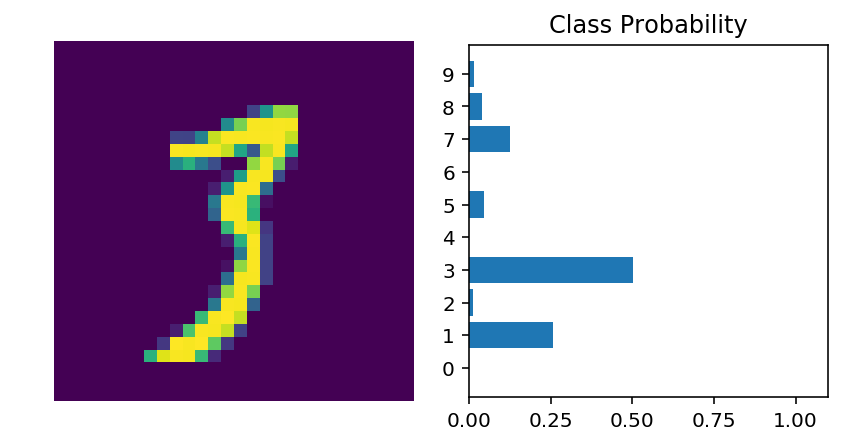

In [27]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)